# Create a forward operator and display sensitivity maps

`
Authors: Eric Larson <larson.eric.d@gmail.com>
         Denis Engemann <denis.engemann@gmail.com>
         Alex Gramfort <alexandre.gramfort@telecom-paristech.fr>
`

License: BSD (3-clause)

First setup some paths. We will use the MNE sample data.

In [1]:
import mne
from mne.datasets import sample
data_path = sample.data_path()

#data_path = '/Users/alex/mne_data/MNE-sample-data'

# the raw file containing the channel location + types
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
# The transformation file obtained by coregistration
trans = data_path + '/MEG/sample/sample_audvis_raw-trans.fif'
# Name of the forward to read (precomputed) or compute
fwd_fname = data_path + '/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif'
# The paths to freesurfer reconstructions
subjects_dir = data_path + '/subjects'

In [2]:
from IPython.display import Image
from mayavi import mlab

# Computing the forward operator

To compute a forward operator we need:

   - a ``-trans.fif`` file that contains the coregistration info
   - a source space
   - the BEM surfaces

## Compute and visualize BEM surfaces

Computing the BEM surfaces requires FreeSurfer and makes use of either of the two following command line tools:

[mne watershed_bem](http://martinos.org/mne/dev/generated/commands.html#mne-watershed-bem)

[mne flash_bem](http://martinos.org/mne/dev/generated/commands.html#mne-flash-bem)

Here, we'll assume it's already computed. It takes a few minutes per subject.

So, let's first look at the BEM surfaces.

For EEG we use 3 layers (inner skull, outer skull, and skin), while for MEG 1 layer (inner skull) is enough.

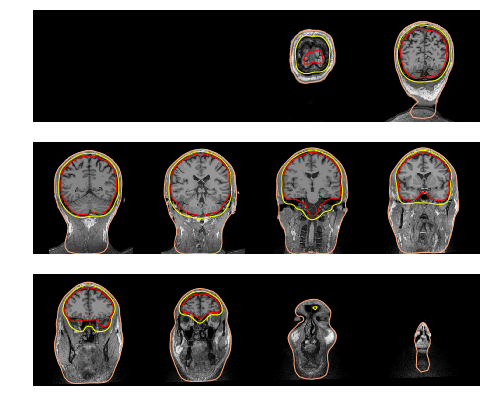

In [3]:
%matplotlib inline
mne.viz.plot_bem(subject='sample', subjects_dir=subjects_dir,
                 orientation='coronal');

### Visualizing the coregistration

The coregistration is the operation that allows to position the head and the sensors in a common coordinate system. In the MNE software, the transformation to align the head and the sensors in stored in a so called *trans* file. It is a FIF file that ends with `-trans.fif`. It can be obtained with ``mne_analyze`` (Unix tools), ``mne.gui.coregistration`` (in Python) or mrilab if you're using a Neuromag system.

For the Python version, see http://martinos.org/mne/dev/generated/mne.gui.coregistration.html

Here, we assume the coregistration is done, so we just visually check the alignment with the following code.

Using outer_skin.surf for head surface.
Getting helmet for system 306m


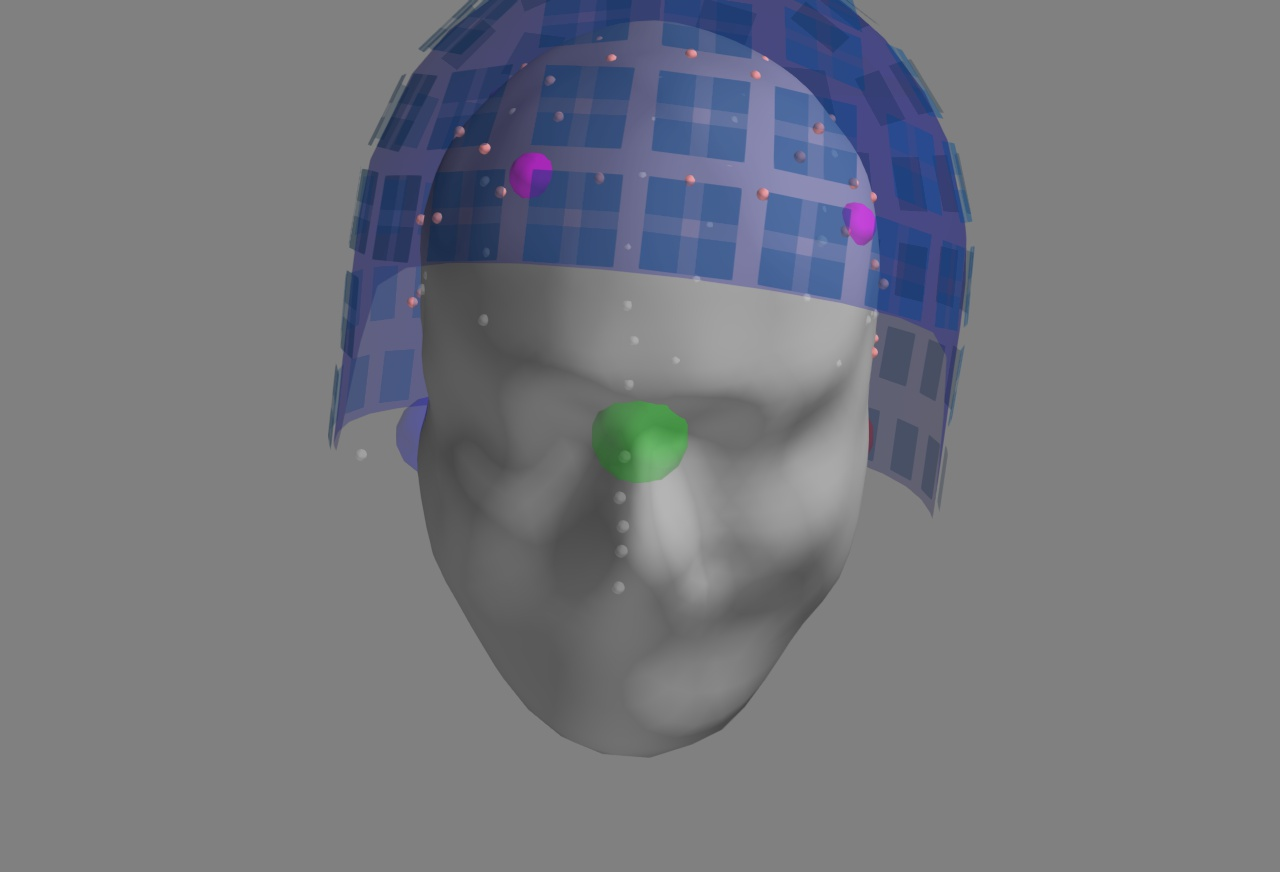

In [4]:
info = mne.io.read_info(raw_fname)
fig = mne.viz.plot_alignment(info, trans, subject='sample', dig=True,
                             subjects_dir=subjects_dir, verbose=True);
mlab.savefig('coreg.jpg')
Image(filename='coreg.jpg', width=500)

In [5]:
mlab.close('all')

/Users/alex/anaconda/envs/mne/lib/python3.6/site-packages/mayavi/tools/figure.py:178: UserWarning: Scene all not managed by mlab
  warnings.warn('Scene %s not managed by mlab' % name)


## Compute Source Space

The source space defines the position of the candidate source locations.

The following code computes such a source space with an OCT-6 resolution.

In [7]:
mne.set_log_level('WARNING')
subject = 'sample'
src = mne.setup_source_space(subject, spacing='oct6',
                             subjects_dir=subjects_dir,
                             add_dist=False)

In [8]:
src

<SourceSpaces: [<surface (lh), n_vertices=155407, n_used=4098, coordinate_frame=MRI (surface RAS)>, <surface (rh), n_vertices=156866, n_used=4098, coordinate_frame=MRI (surface RAS)>]>

``src`` contains two parts, one for the left hemisphere (4098 locations) and one for the right hemisphere (4098 locations).

In [9]:
fig = mne.viz.plot_alignment(info, trans, subject='sample', dig=False, src=src,
                             subjects_dir=subjects_dir, verbose=True, meg=False, eeg=False);

Using outer_skin.surf for head surface.


In [10]:
mne.viz.plot_alignment(info, trans=trans, subject='sample',
                       src=src, subjects_dir=subjects_dir, dig=True,
                       surfaces=['head-dense', 'white'], coord_frame='meg')

In [11]:
mlab.close()

### Compute forward solution

We can now compute the forward solution.

To reduce computational load, we'll just compute a single layer BEM
(just inner skull) that can then be used for MEG (not EEG).

In [12]:
conductivity = (0.3,)  # for single layer
# conductivity = (0.3, 0.006, 0.3)  # for three layers
model = mne.make_bem_model(subject='sample', ico=4,
                           conductivity=conductivity,
                           subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)

In [13]:
fwd = mne.make_forward_solution(raw_fname, trans=trans, src=src, bem=bem,
                                meg=True, # include MEG channels
                                eeg=False, # include EEG channels
                                mindist=5.0, # ignore sources <= 5mm from inner skull
                                n_jobs=1) # number of jobs to run in parallel

In [14]:
fwd

<Forward | MEG channels: 306 | EEG channels: 0 | Source space: Surface with 7498 vertices | Source orientation: Free>

Or read the EEG/MEG file from disk

In [15]:
fwd = mne.read_forward_solution(fwd_fname)

In [16]:
fwd

<Forward | MEG channels: 306 | EEG channels: 60 | Source space: Surface with 7498 vertices | Source orientation: Free>

Convert to surface orientation for cortically constrained inverse modeling:

In [17]:
fwd = mne.convert_forward_solution(fwd, surf_ori=True)
leadfield = fwd['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

Leadfield size : 366 sensors x 22494 dipoles


Compute sensitivity maps:

In [18]:
grad_map = mne.sensitivity_map(fwd, ch_type='grad', mode='fixed')
mag_map = mne.sensitivity_map(fwd, ch_type='mag', mode='fixed')
eeg_map = mne.sensitivity_map(fwd, ch_type='eeg', mode='fixed')

# Show gain matrix a.k.a. leadfield matrix with sensitivy map

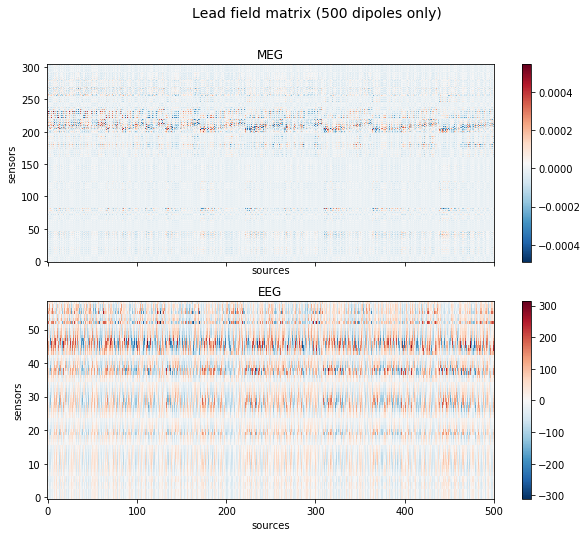

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

picks_meg = mne.pick_types(fwd['info'], meg=True, eeg=False)
picks_eeg = mne.pick_types(fwd['info'], meg=False, eeg=True)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)  
fig.suptitle('Lead field matrix (500 dipoles only)', fontsize=14)

for ax, picks, ch_type in zip(axes, [picks_meg, picks_eeg], ['meg', 'eeg']):
   im = ax.imshow(leadfield[picks, :500], origin='lower', aspect='auto', cmap='RdBu_r')
   ax.set_title(ch_type.upper())
   ax.set_xlabel('sources')
   ax.set_ylabel('sensors')
   plt.colorbar(im, ax=ax, cmap='RdBu_r')

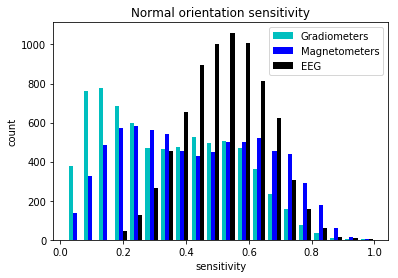

In [20]:
plt.hist([grad_map.data.ravel(), mag_map.data.ravel(), eeg_map.data.ravel()],
          bins=20, label=['Gradiometers', 'Magnetometers', 'EEG'],
         color=['c', 'b', 'k'])
plt.legend()
plt.title('Normal orientation sensitivity')
plt.xlabel('sensitivity')
plt.ylabel('count');

Uncomment the lines below to view

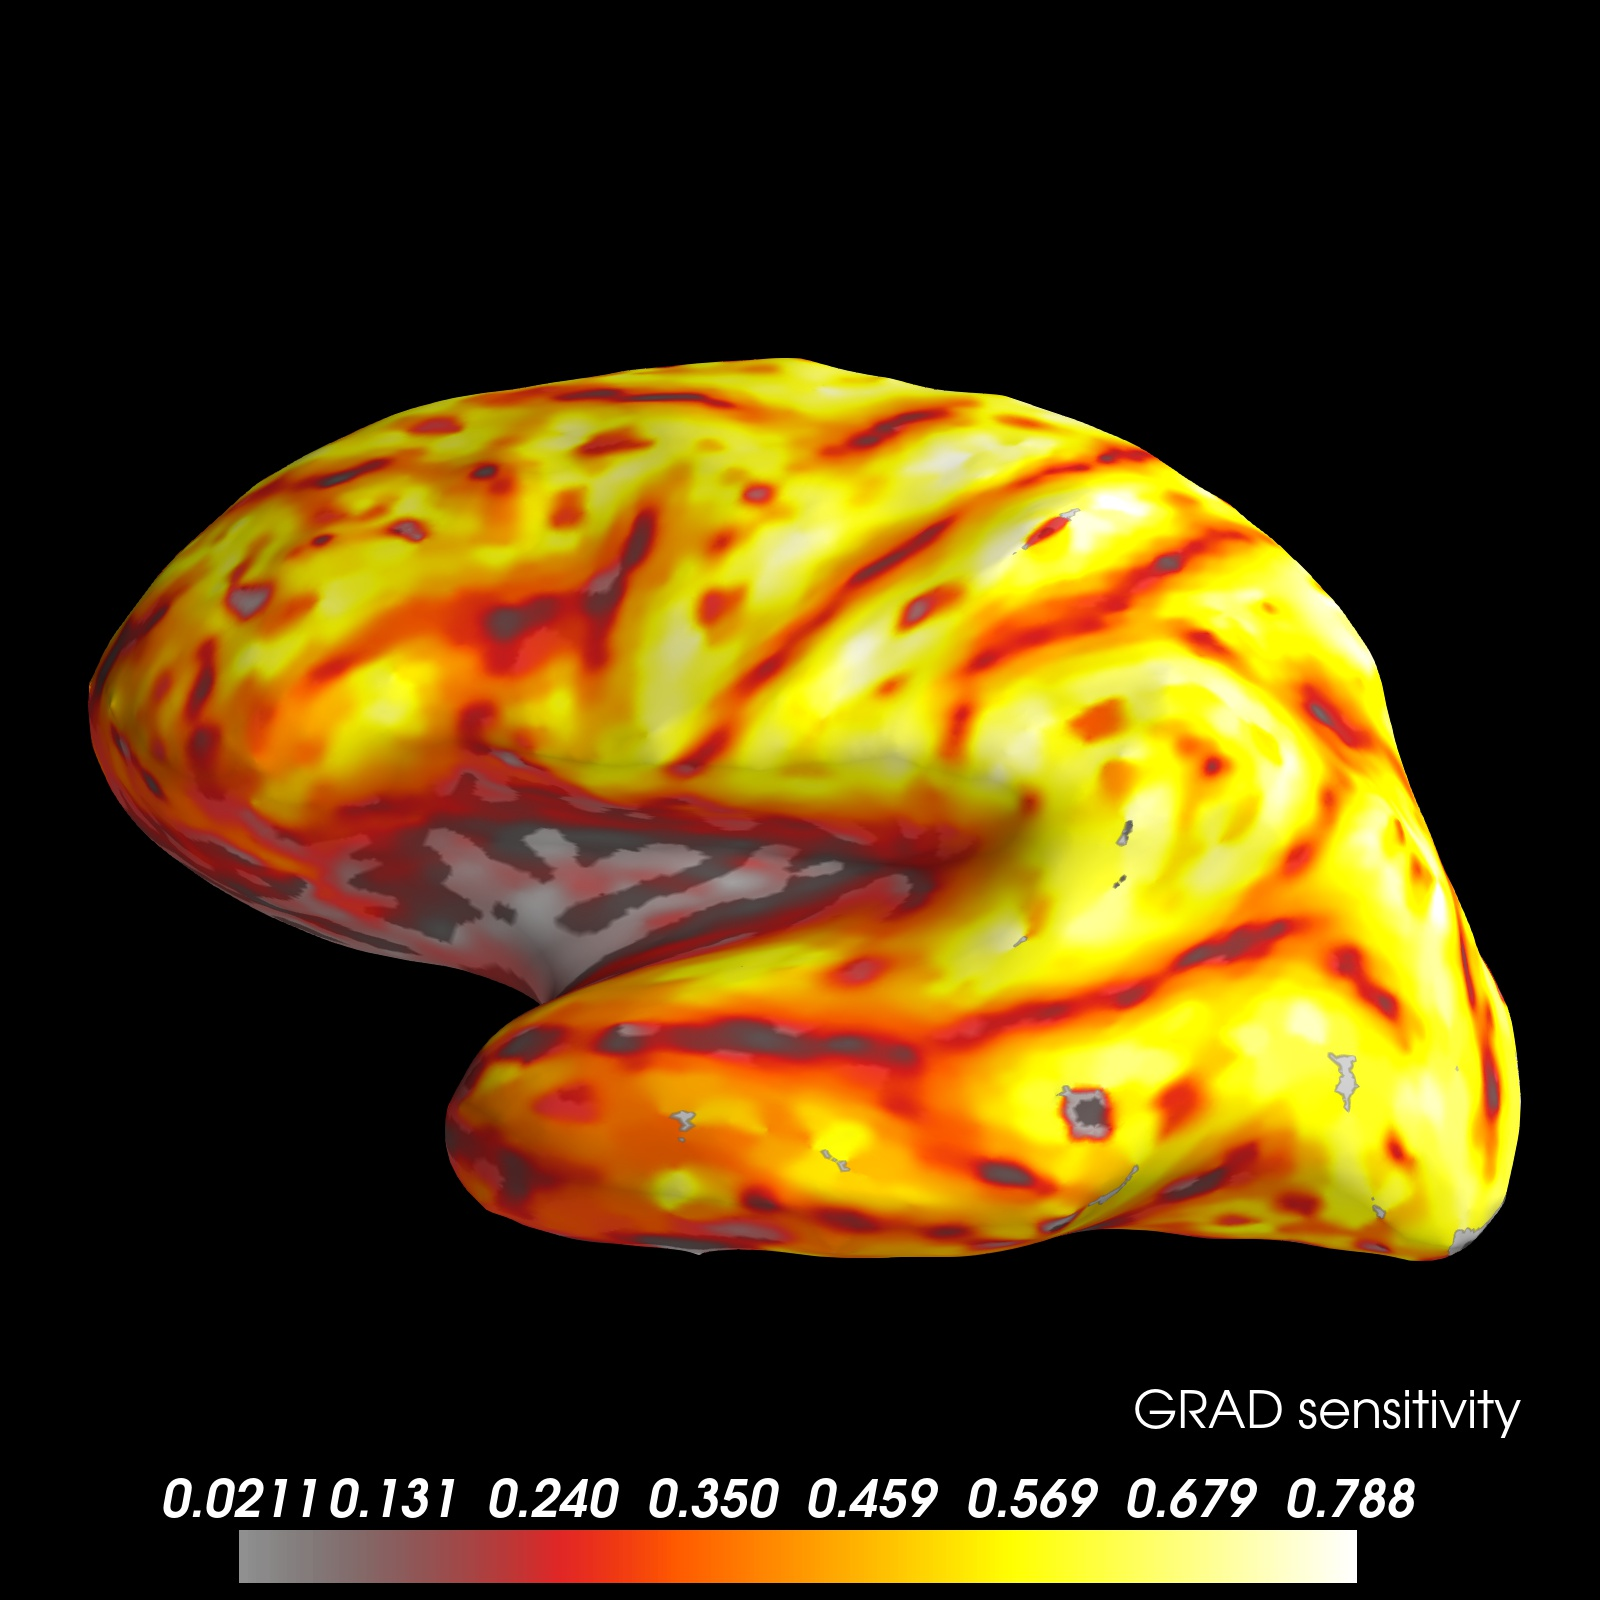

In [21]:
# enable correct backend for 3d plotting
%matplotlib qt
clim = dict(kind='percent', lims=(0.0, 50, 99), smoothing_steps=3)  # let's see single dipoles
brain = grad_map.plot(subject='sample', time_label='GRAD sensitivity',
                     subjects_dir=subjects_dir, clim=clim, smoothing_steps=8);
view = 'lat'
brain.show_view(view)
brain.save_image('sensitivity_map_grad_%s.jpg' % view)
Image(filename='sensitivity_map_grad_%s.jpg' % view, width=400)

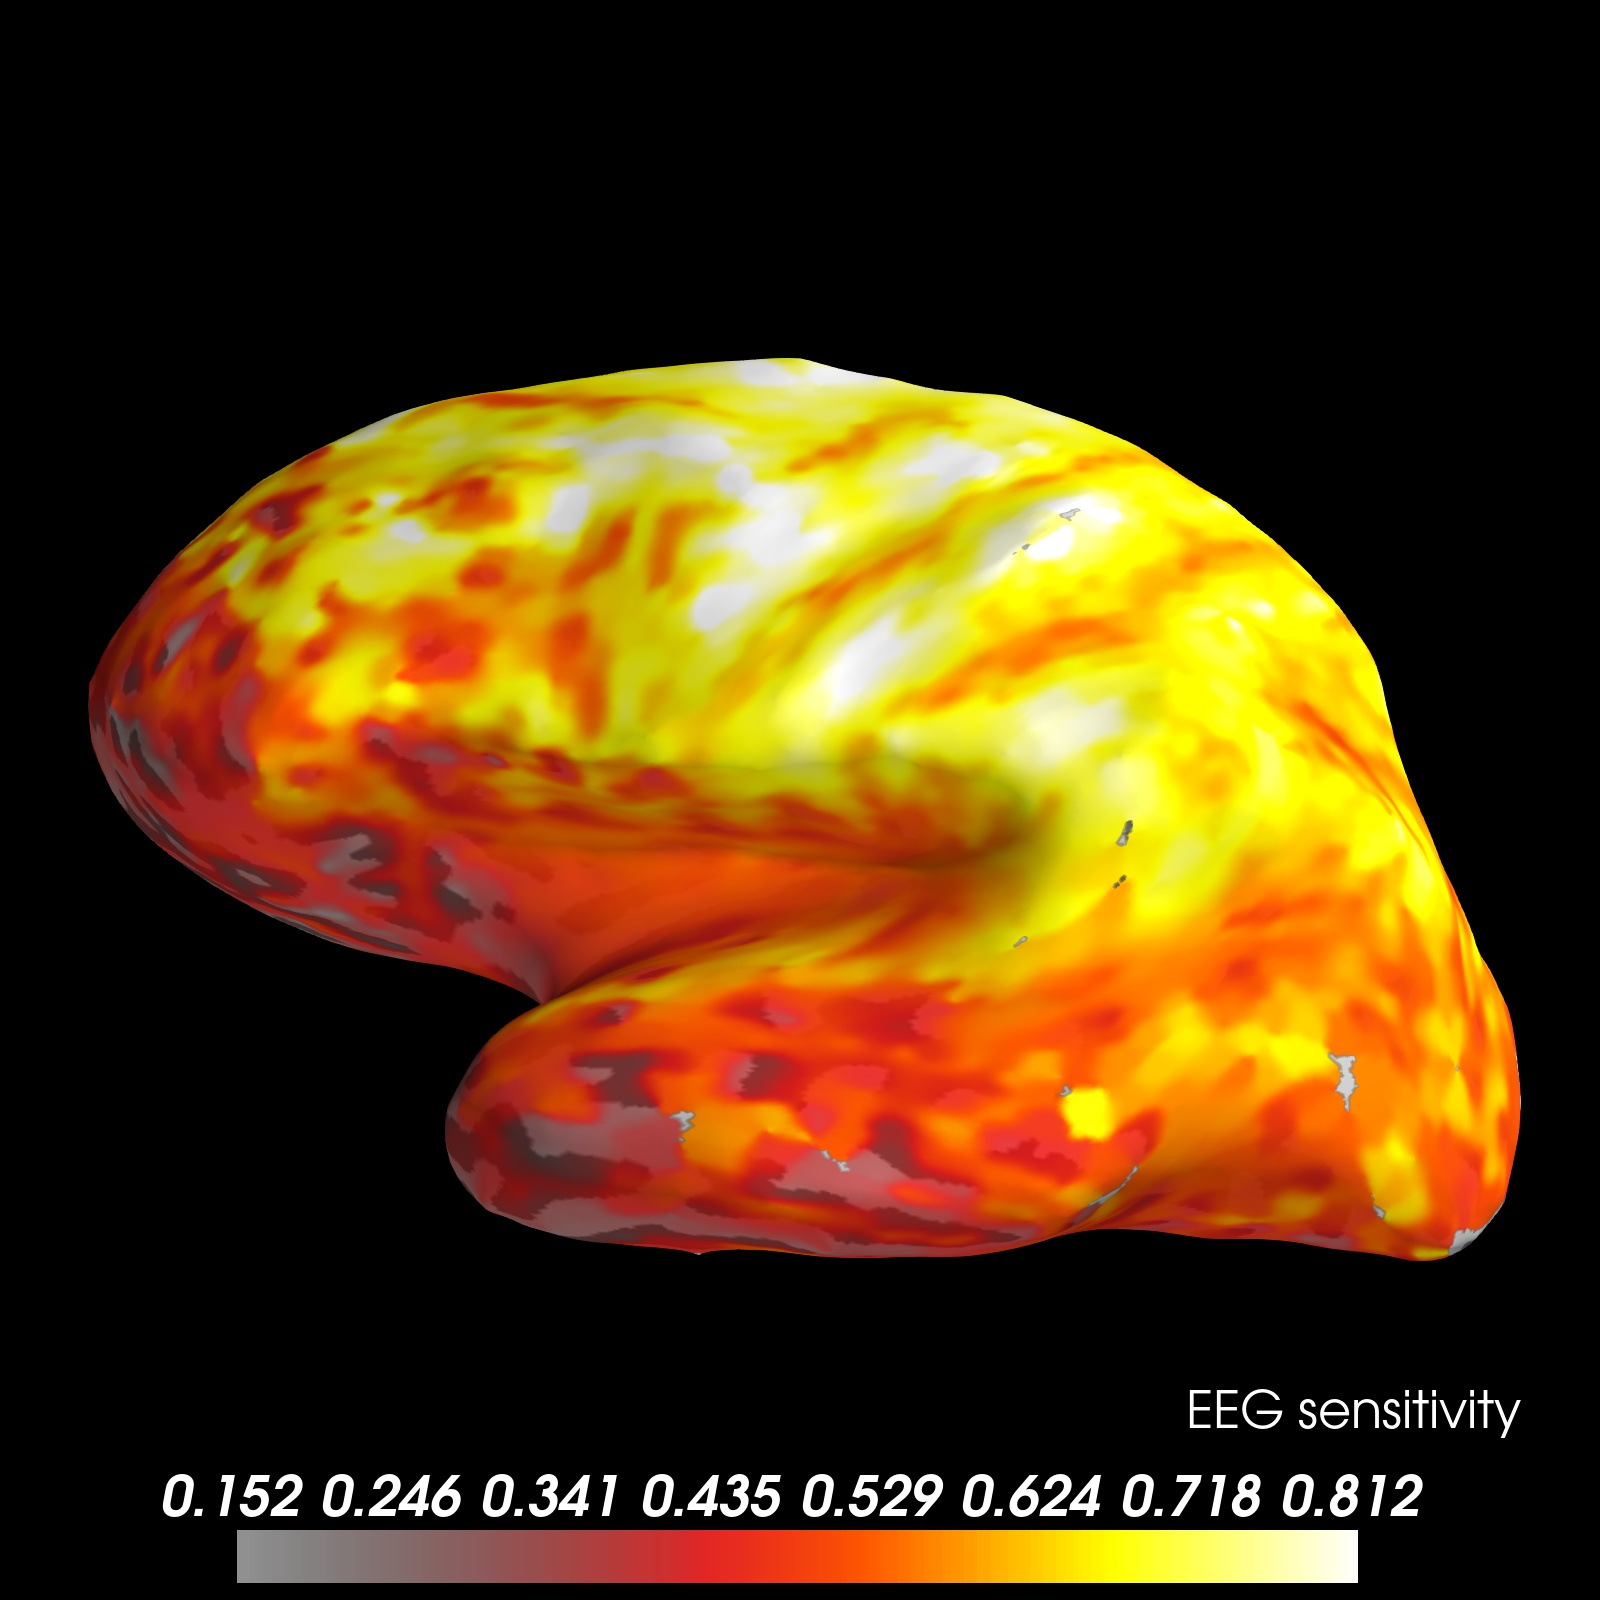

In [22]:
# enable correct backend for 3d plotting
%matplotlib qt
clim = dict(kind='percent', lims=(0.0, 50, 99), smoothing_steps=3)  # let's see single dipoles
brain = eeg_map.plot(subject='sample', time_label='EEG sensitivity',
                     subjects_dir=subjects_dir, clim=clim, smoothing_steps=8);
view = 'lat'
brain.show_view(view)
brain.save_image('sensitivity_map_eeg_%s.jpg' % view)
Image(filename='sensitivity_map_eeg_%s.jpg' % view, width=400)

## Exercise

Plot the sensitivity maps for EEG and compare it with the MEG. Can you justify the claims that:

- MEG is not sensitive to radial sources
- EEG is more sensitive to deep sources

How will the MEG sensitivity maps and histograms change if you use a free instead of a fixed orientation?

Try changing the `mode` parameter in `mne.sensitivity_map` accordingly.

Why don't we see any dipoles on the gyri?

# Visualizing field lines based on coregistration

In [23]:
from mne import read_evokeds
from mne.datasets import sample
from mne import make_field_map
data_path = sample.data_path()

raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'

subjects_dir = data_path + '/subjects'
evoked_fname = data_path + '/MEG/sample/sample_audvis-ave.fif'
trans_fname = data_path + '/MEG/sample/sample_audvis_raw-trans.fif'

In [24]:
make_field_map?

In [25]:
# If trans_fname is set to None then only MEG estimates can be visualized

condition = 'Left Auditory'
evoked_fname = data_path + '/MEG/sample/sample_audvis-ave.fif'
evoked = mne.read_evokeds(evoked_fname, condition=condition, baseline=(-0.2, 0.0))

# Compute the field maps to project MEG and EEG data to MEG helmet
# and scalp surface
maps = mne.make_field_map(evoked, trans=trans, subject='sample',
                      subjects_dir=subjects_dir, n_jobs=1)

# explore several points in time
field_map = evoked.plot_field(maps, time=.1);

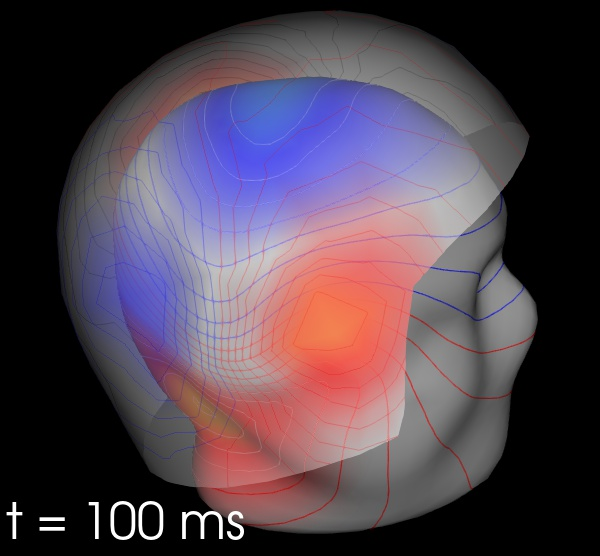

In [25]:
from mayavi import mlab
mlab.savefig('field_map.jpg')
from IPython.display import Image
Image(filename='field_map.jpg', width=800)